# Flight Status Prediction
2022-12-13  
Kelsey Liu  
Data Source: https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022/discussion

### Relevant Definition

**1. How are flight delays calculated?**  
A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS). Arrival performance is based on arrival at the gate. Departure performance is based on departure from the gate. Therefore, `DepDel15` is a key indicator of whether a flight is considered delayed.

**2. `DepartureDelayGroups`:**
Departure Delay intervals, every (15 minutes from <-15 to >180)

**3. How are actual time of arrival and departure measured?**  
Actual arrival, departure and elapsed times shall be measured by
the times at which the aircraft arrived at and departed from the gate or
passenger loading area.

## 0. Import Libraries and Read Data

In [63]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from datetime import datetime

pd.set_option("display.max_columns", None)
plt.style.use("ggplot")
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [64]:
### Data exploration and overview
# df_2020 = pd.read_parquet("../FlightStatus/RawData/Combined_Flights_2020.parquet", engine="fastparquet")

# df_2020.columns
# df_2020.head()
# df_2020.loc[df_2020["DepDel15"] == 1]
# df_2020.info()

In [65]:
# We filter out columns that we deem not useful in our analysis and model building,
# also because our goal is to predict the flight status "before" the flight depart,
# we need to exclude those post flight records (except our target varable), ex. DepTime (Actual departure time)

columns_subset = [
    "Year",
    "DayofMonth",
    "Month",
    "DayOfWeek",
    "Airline",
    "Origin",
    "OriginState",
    "Dest",
    "DestState",
    "Distance",
    "Cancelled",  # 0, 1- Classifier
    "Diverted",  # 0, 1- Classifier
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "DepartureDelayGroups",  # [-2, 12], Classifier, Clustering
    "ArrivalDelayGroups",  # [-2, 12], Classifier, Clustering
    "DepDel15",  # 0, 1- Classifier
    "ArrDel15"  # 0, 1- Classifier
    #'Quarter', 'DepDelayMinutes', 'ArrDelayMinutes', 'AirTime',
    #'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', "OriginCityName", "DestCityName",
    #'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline',
    #'Operating_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
    #'Tail_Number','OriginAirportID','OriginAirportSeqID',
    #'OriginCityMarketID','OriginStateName', 'OriginStateFips', 'DestAirportID', 'DestAirportSeqID',
    #'DestCityMarketID', 'DestStateName', 'DestStateFips','OriginWac', 'DestWac', 'DepTimeBlk', 'TaxiOut',
    #'WheelsOff', 'WheelsOn', 'TaxiIn', 'ArrTimeBlk', 'DistanceGroup', 'DivAirportLandings'
    #'ArrTime', "ArrDelay", "DepTime", "DepDelay", "Flight_Number_Operating_Airline", "ActualElapsedTime"
]

df_2020 = pd.read_parquet(
    "../FlightStatus/RawData/Combined_Flights_2020.parquet",
    engine="fastparquet",
    columns=columns_subset,
)

## 1. EDA and Data Visualization

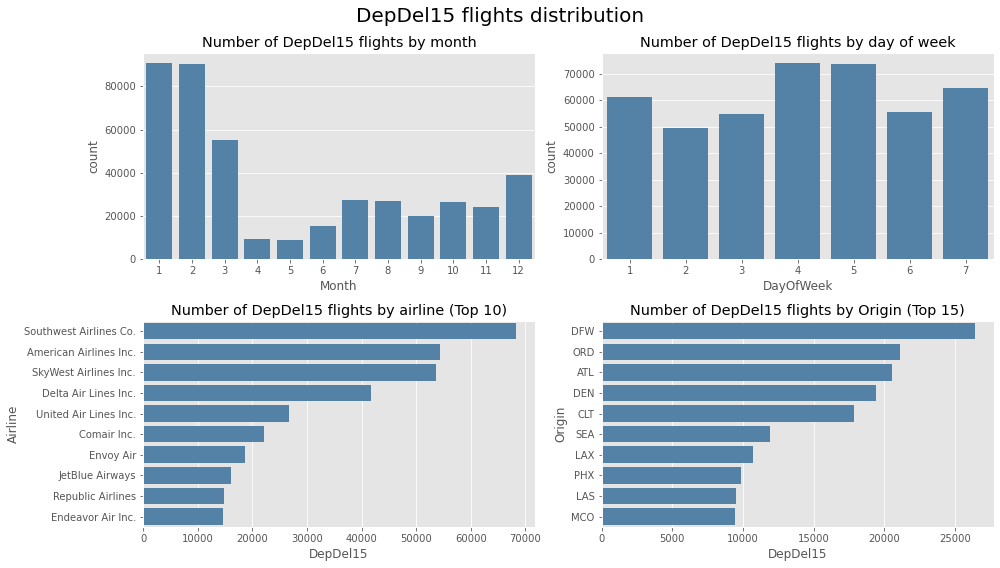

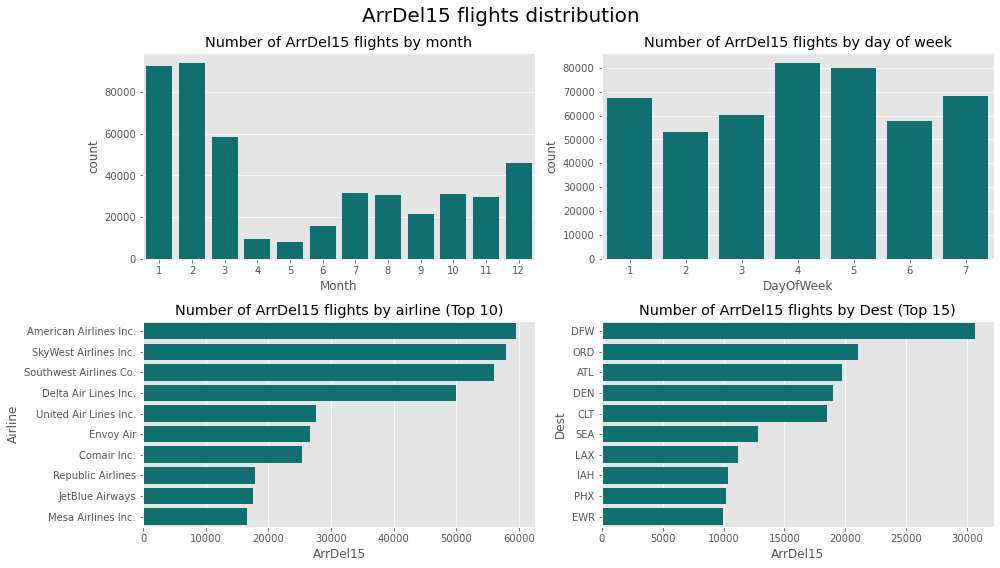

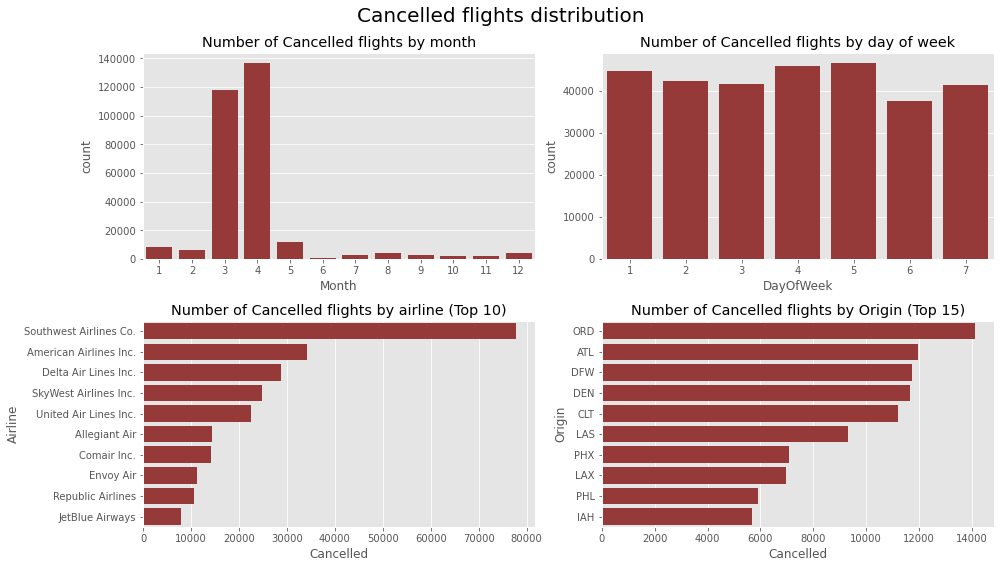

In [66]:
color = ["steelblue", "teal", "brown"]
column = ["DepDel15", "ArrDel15", "Cancelled"]
airport = ["Origin", "Dest", "Origin"]

for i in range(3):
    # Plot Number of ___ flights
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=False)
    fig.suptitle(f"{column[i]} flights distribution", size=20)

    ## By month
    sns.countplot(
        ax=axes[0, 0],
        x="Month",
        data=df_2020.query(f"{column[i]} == 1"),
        color=color[i],
    )
    axes[0, 0].set_title(f"Number of {column[i]} flights by month")

    ## By day of week
    sns.countplot(
        ax=axes[0, 1],
        x="DayOfWeek",
        data=df_2020.query(f"{column[i]} == 1"),
        color=color[i],
    )
    axes[0, 1].set_title(f"Number of {column[i]} flights by day of week")

    ## By airline
    sns.barplot(
        ax=axes[1, 0],
        x=column[i],
        y="Airline",
        color=color[i],
        data=df_2020.query(f"{column[i]} == 1")
        .groupby("Airline", as_index=False)
        .sum(column[i])
        .sort_values(column[i], ascending=False)
        .head(10),
    )
    axes[1, 0].set_title(f"Number of {column[i]} flights by airline (Top 10)")

    ## By origin airport
    sns.barplot(
        ax=axes[1, 1],
        x=column[i],
        y=airport[i],
        color=color[i],
        data=df_2020.query(f"{column[i]} == 1")
        .groupby(airport[i], as_index=False)
        .sum(column[i])
        .sort_values(column[i], ascending=False)
        .head(10),
    )
    axes[1, 1].set_title(f"Number of {column[i]} flights by {airport[i]} (Top 15)")

    plt.tight_layout()
    plt.show()

From Above plots, we can see that the DepDel15 distribution is very similar to ArrDel15's, showing a possibly high correlation, but they are both very different from the cancelled flight distribution.
In DepDel15 and ArrDel15 plots, distribution by Month and by DayOfWeek look almost the same, which can be due to higher volume air traffic leading to higher possibly of delayed, or simply because it increase along with the total number of flights (delayed percentage remains the same). To understand the reason behind, we can look into the total flights distribution. On the other hand, the order of top 10 and top 15 airports of departure and arrival delayed flights shows a little difference, but most of them are major airlines/ airports so it is rather understandable.

<AxesSubplot:title={'center':'Total flights by airlines'}, ylabel='Airline'>

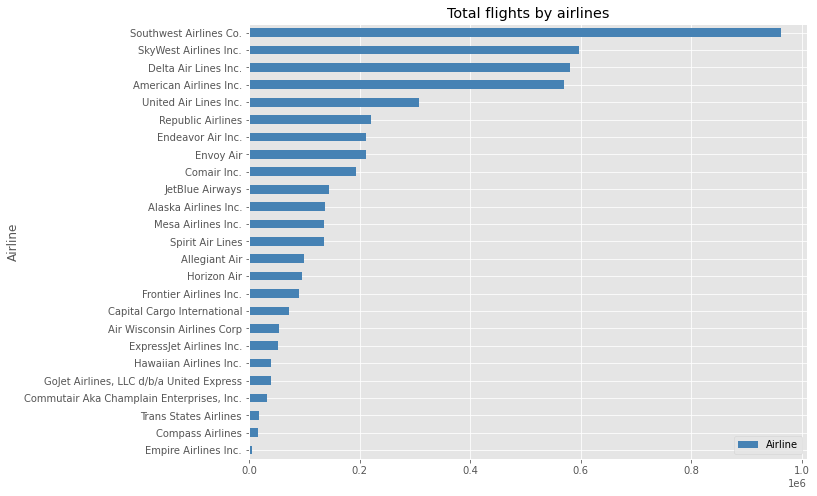

In [67]:
# Total flights by airlines
Total = df_2020.groupby("Airline")["Airline"].count().sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Total flights by airlines")
pd.DataFrame(Total).plot.barh(ax=ax, color="steelblue")

<AxesSubplot:title={'center':'Cancelled flights Percentage by airlines'}, ylabel='Airline'>

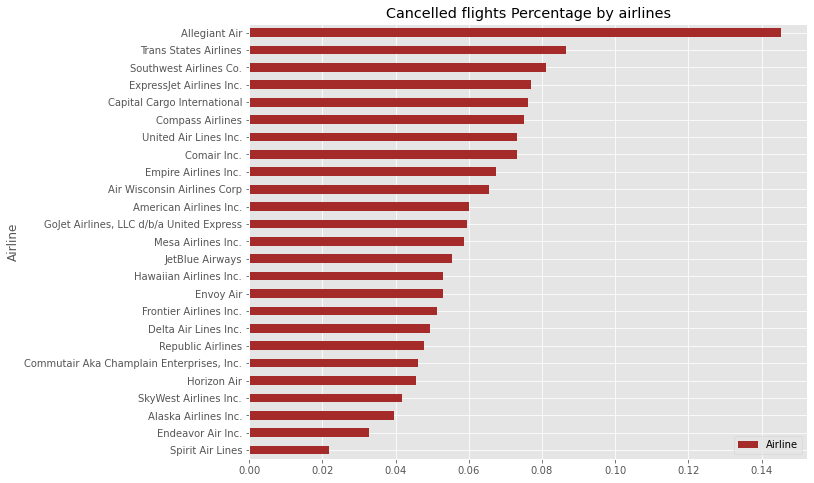

In [68]:
# Cancelled flights Percentage by airlines
Cancelled_percentage = (
    (df_2020.query("Cancelled == True").groupby("Airline")["Airline"].count())
    / (df_2020.groupby("Airline")["Airline"].count())
).sort_values()

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title("Cancelled flights Percentage by airlines")
pd.DataFrame(Cancelled_percentage).plot.barh(ax=ax, color="brown")

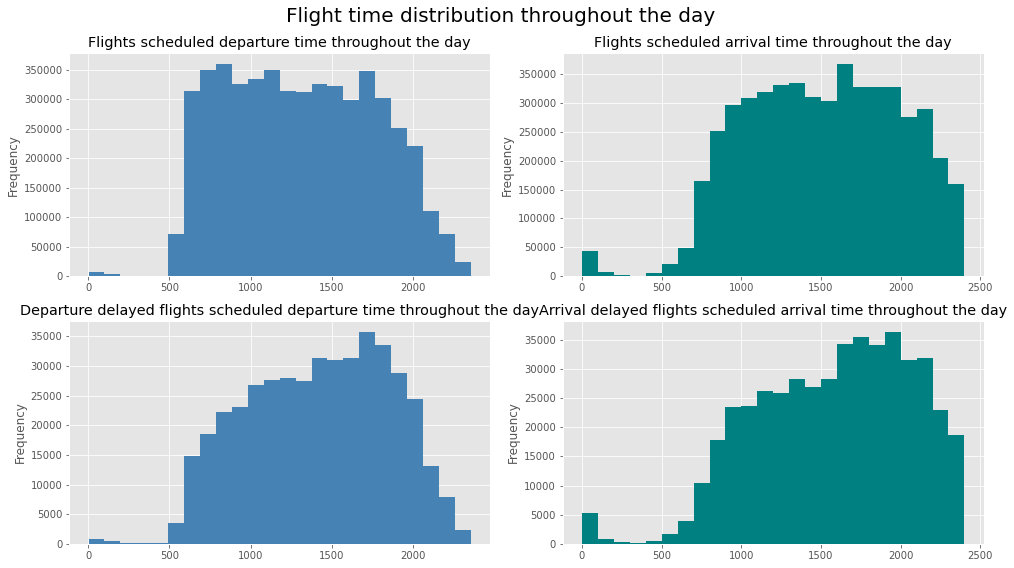

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=False)
fig.suptitle("Flight time distribution throughout the day", size=20)

# Flights scheduled departure time throughout the day
df_2020.CRSDepTime.plot.hist(ax=axes[0, 0], color="steelblue", bins=24)
axes[0, 0].set_title("Flights scheduled departure time throughout the day")

# Flights scheduled arrival time throughout the day
df_2020.CRSArrTime.plot.hist(ax=axes[0, 1], color="teal", bins=24)
axes[0, 1].set_title("Flights scheduled arrival time throughout the day")

# Departure Delayed flights departure time throughout the day
df_2020.query("DepDel15 == True").CRSDepTime.plot.hist(
    ax=axes[1, 0], color="steelblue", bins=24
)
axes[1, 0].set_title(
    "Departure delayed flights scheduled departure time throughout the day"
)

# Arrival Delayed flights arrival time throughout the day
df_2020.query("ArrDel15 == True").CRSArrTime.plot.hist(
    ax=axes[1, 1], color="teal", bins=24
)
axes[1, 1].set_title(
    "Arrival delayed flights scheduled arrival time throughout the day"
)

plt.tight_layout()
plt.show()

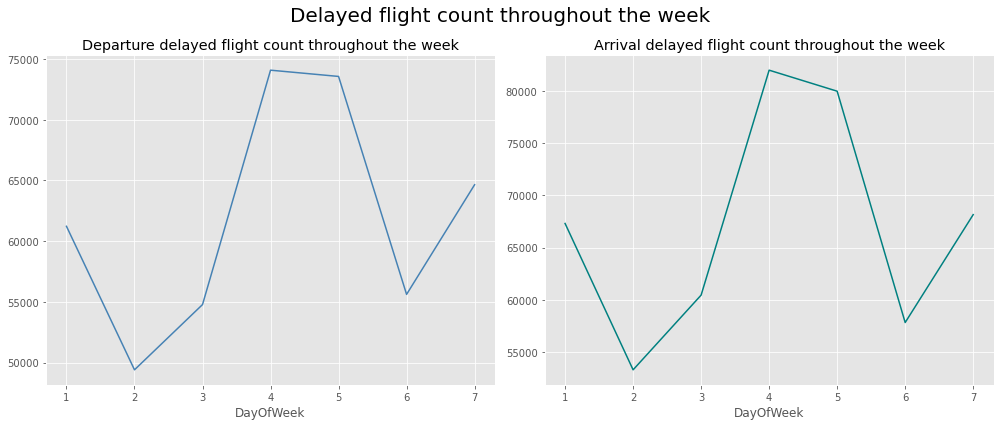

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
fig.suptitle("Delayed flight count throughout the week", size=20)

# Flights scheduled departure time throughout the day
df_2020.query("DepDel15 == 1").groupby("DayOfWeek")["DayOfWeek"].count().plot.line(
    ax=axes[0], color="steelblue"
)
axes[0].set_title("Departure delayed flight count throughout the week")

# Flights scheduled arrival time throughout the day
df_2020.query("ArrDel15 == 1").groupby("DayOfWeek")["DayOfWeek"].count().plot.line(
    ax=axes[1], color="teal"
)
axes[1].set_title("Arrival delayed flight count throughout the week")

plt.tight_layout()
plt.show()

In [71]:
c_p = round(len(df_2020.query("Cancelled == 1")) / len(df_2020) * 100, 0)
print(f"The percentage of cancelled flights in 2020 is:\n{c_p} %")

The percentage of cancelled flights in 2020 is:
6.0 %


In [72]:
d_p = round(len(df_2020.query("DepDel15 == 1")) / len(df_2020) * 100, 0)
print(f"The percentage of departure delayed flights in 2020 is:\n{d_p} %")

The percentage of departure delayed flights in 2020 is:
9.0 %


In [73]:
a_p = round(len(df_2020.query("ArrDel15 == 1")) / len(df_2020) * 100, 0)
print(f"The percentage of departure delayed flights in 2020 is:\n{a_p} %")

The percentage of departure delayed flights in 2020 is:
9.0 %


## 2. Data Cleaning and preprocessing

In [74]:
df_2020 = df_2020.reset_index(drop=True)

In [75]:
df_2020.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5022397 entries, 0 to 5022396
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Year                  5022397 non-null  int64  
 1   DayofMonth            5022397 non-null  int64  
 2   Month                 5022397 non-null  int64  
 3   DayOfWeek             5022397 non-null  int64  
 4   Airline               5022397 non-null  object 
 5   Origin                5022397 non-null  object 
 6   OriginState           5022397 non-null  object 
 7   Dest                  5022397 non-null  object 
 8   DestState             5022397 non-null  object 
 9   Distance              5022397 non-null  float64
 10  Cancelled             5022397 non-null  bool   
 11  Diverted              5022397 non-null  bool   
 12  CRSDepTime            5022397 non-null  int64  
 13  CRSArrTime            5022397 non-null  int64  
 14  CRSElapsedTime        5022392 non-

In [76]:
df_2020.OriginState.unique()

array(['PA', 'NC', 'SC', 'FL', 'KY', 'ME', 'NY', 'OK', 'TN', 'OH', 'WI',
       'MI', 'VA', 'NH', 'SD', 'GA', 'IN', 'RI', 'CT', 'IA', 'AL', 'TX',
       'MS', 'MD', 'MO', 'AR', 'WV', 'VT', 'LA', 'IL', 'NE', 'NV', 'CO',
       'CA', 'PR', 'MN', 'NJ', 'WA', 'UT', 'AZ', 'KS', 'ND', 'MT', 'OR',
       'MA', 'NM', 'AK', 'HI', 'ID', 'WY', 'TT', 'VI'], dtype=object)

In [77]:
# Conver state code to 5 'Region's: 'West', 'Northeast', 'South', 'Midwest', 'Southwest'
states = {
    "AK": "Other",
    "AL": "South",
    "AR": "South",
    "AS": "Other",
    "AZ": "West",
    "CA": "West",
    "CO": "West",
    "CT": "Northeast",
    "DC": "Northeast",
    "DE": "Northeast",
    "FL": "South",
    "GA": "South",
    "GU": "Other",
    "HI": "Other",
    "IA": "Midwest",
    "ID": "West",
    "IL": "Midwest",
    "IN": "Midwest",
    "KS": "Midwest",
    "KY": "South",
    "LA": "South",
    "MA": "Northeast",
    "MD": "Northeast",
    "ME": "Northeast",
    "MI": "West",
    "MN": "Midwest",
    "MO": "Midwest",
    "MP": "Other",
    "MS": "South",
    "MT": "West",
    "NA": "Other",
    "NC": "South",
    "ND": "Midwest",
    "NE": "West",
    "NH": "Northeast",
    "NJ": "Northeast",
    "NM": "West",
    "NV": "West",
    "NY": "Northeast",
    "OH": "Midwest",
    "OK": "South",
    "OR": "West",
    "PA": "Northeast",
    "PR": "Other",
    "RI": "Northeast",
    "SC": "South",
    "SD": "Midwest",
    "TN": "South",
    "TX": "South",
    "UT": "West",
    "VA": "South",
    "VI": "Other",
    "VT": "Northeast",
    "WA": "West",
    "WI": "Midwest",
    "WV": "South",
    "WY": "West",
    "TT": "Other",
}


df_2020["OriginRegion"] = df_2020["OriginState"].map(states)
df_2020["DestRegion"] = df_2020["DestState"].map(states)

df_2020 = df_2020.drop(["OriginState", "DestState"], axis=1)

# check:
## df_2020[df_2020.OriginRegion].unique()
## df_2020[df_2020.DestRegion].unique()

In [78]:
# df_2020.info()
df_2020.columns

Index(['Year', 'DayofMonth', 'Month', 'DayOfWeek', 'Airline', 'Origin', 'Dest',
       'Distance', 'Cancelled', 'Diverted', 'CRSDepTime', 'CRSArrTime',
       'CRSElapsedTime', 'DepartureDelayGroups', 'ArrivalDelayGroups',
       'DepDel15', 'ArrDel15', 'OriginRegion', 'DestRegion'],
      dtype='object')

In [79]:
# Re-format the Data type

## Category
Category = [
    "Airline",
    "Origin",
    "Dest",
    "OriginRegion",
    "DestRegion",
]
for col in Category:
    df_2020[col] = df_2020[col].astype("category")

## Bool
Boolean = ["DepDel15", "ArrDel15"]
for col in Boolean:
    df_2020[col] = df_2020[col].astype("bool")

In [80]:
df_2020.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5022397 entries, 0 to 5022396
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   Year                  5022397 non-null  int64   
 1   DayofMonth            5022397 non-null  int64   
 2   Month                 5022397 non-null  int64   
 3   DayOfWeek             5022397 non-null  int64   
 4   Airline               5022397 non-null  category
 5   Origin                5022397 non-null  category
 6   Dest                  5022397 non-null  category
 7   Distance              5022397 non-null  float64 
 8   Cancelled             5022397 non-null  bool    
 9   Diverted              5022397 non-null  bool    
 10  CRSDepTime            5022397 non-null  int64   
 11  CRSArrTime            5022397 non-null  int64   
 12  CRSElapsedTime        5022392 non-null  float64 
 13  DepartureDelayGroups  4722714 non-null  float64 
 14  ArrivalDelayGroups

In [81]:
df_2020.isna().sum()

Year                         0
DayofMonth                   0
Month                        0
DayOfWeek                    0
Airline                      0
Origin                       0
Dest                         0
Distance                     0
Cancelled                    0
Diverted                     0
CRSDepTime                   0
CRSArrTime                   0
CRSElapsedTime               5
DepartureDelayGroups    299683
ArrivalDelayGroups      309467
DepDel15                     0
ArrDel15                     0
OriginRegion                 0
DestRegion                   0
dtype: int64

In [82]:
# CRSElapsedTime (NaN)              5
df_2020[df_2020.CRSElapsedTime.isna()]  # Can be dropped
df_2020 = df_2020[~df_2020.CRSElapsedTime.isna()]

In [83]:
# DepartureDelayGroups (NaN)    299683
# df_2020["DepartureDelayGroups"].unique()
# Check if the NA comes from cancelled / diverted flight
df_2020[df_2020.DepartureDelayGroups.isna()].Cancelled.unique()

array([ True])

In [84]:
# ArrivalDelayGroups (NaN)      309467
# df_2020["ArrivalDelayGroups"].unique()
# Check if the NA comes from cancelled / diverted flight

df_2020[df_2020.ArrivalDelayGroups.isna()].query(
    "Cancelled == False & Diverted == False"
)

,Year,DayofMonth,Month,DayOfWeek,Airline,Origin,Dest,Distance,Cancelled,Diverted,CRSDepTime,CRSArrTime,CRSElapsedTime,DepartureDelayGroups,ArrivalDelayGroups,DepDel15,ArrDel15,OriginRegion,DestRegion
929501,2020,25,3,3,Republic Airlines,DTW,IND,231.0,False,False,830,947,77.0,-1.0,NaN,False,True,West,Midwest


In [85]:
# Only one NA record that came from neither cancelled nor diverted, can be dropped (index:929501)
df_2020 = df_2020.drop(929501)

In [86]:
# Since the NA value means it's either cancelled or diverted, we replace the NA with extreme value 99.
columns = ["DepartureDelayGroups", "ArrivalDelayGroups"]

for col in columns:
    df_2020[col] = df_2020[col].fillna("99")

In [87]:
df_2020.isna().sum()

Year                    0
DayofMonth              0
Month                   0
DayOfWeek               0
Airline                 0
Origin                  0
Dest                    0
Distance                0
Cancelled               0
Diverted                0
CRSDepTime              0
CRSArrTime              0
CRSElapsedTime          0
DepartureDelayGroups    0
ArrivalDelayGroups      0
DepDel15                0
ArrDel15                0
OriginRegion            0
DestRegion              0
dtype: int64

## 3. User Function Definition

In [88]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [89]:
def standardize(df):

    # from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(df)
    scaled = scaler.transform(df)

    return scaled

In [90]:
def plot_knn(array, n_neighbors=5):

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(array)
    distances, indices = nbrs.kneighbors(array)
    sort_distances = np.sort(distances, axis=0)
    k_dist = sort_distances[:, n_neighbors - 1]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_ylabel("k-NN distance")
    ax.set_xlabel("Sorted observations")
    plt.plot(k_dist)

    return ax

In [91]:
def fit_tsne(df, n_components=2, learning_rate=100):

    model = TSNE(n_components=n_components, learning_rate=learning_rate)
    reduced = model.fit_transform(df)

    return model, reduced

In [92]:
def fit_pca(df, n_components):

    # from sklearn.decomposition import PCA
    pca = PCA(n_components)
    pca.fit(df)

    return pca

In [93]:
def plot_variance(pca):

    fig, ax = plt.subplots(figsize=(10, 6))

    # Decorate the plot
    ax.set_xlabel("Dimension #")
    ax.set_ylabel("Explained Variance Ratio")
    ax.set_title("Fraction of Explained Variance")
    ax.plot(pca.explained_variance_ratio_)

    return ax

In [94]:
def reduce(pca, array):

    reduced = pca.transform(array)

    return reduced

In [95]:
def cluster_kmeans(array, random_state, n_clusters=4):

    model = KMeans(n_clusters=n_clusters, random_state=random_state)

    model.fit(array)

    clusters = model.predict(array)

    return model, clusters


# here we return fitted (model) and predicted (clusters) arrays as a tuple

In [96]:
def cluster_dbscan(array, eps=0.5, min_samples=5):

    model = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = model.fit_predict(array)
    n_cluster = len(set(clusters))

    return model, clusters, n_cluster

In [97]:
def plot_inertia(array, start=1, end=10):

    x_axis = range(start, end + 1)
    inertia = []

    for k in x_axis:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k, random_state=check_random_state(0))

        # Fit model to samples
        model.fit(array)

        # Append the inertia to the list of inertias
        inertia.append(model.inertia_)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_title("The elbow method")
    ax.set_ylabel("Inertia", size=12)
    ax.set_xlabel("Number of clusters", size=12)
    plt.plot(x_axis, inertia)

    return ax

## 4. Data Modeling: Classification

### 4.1 Prediction on departure delay (DepDel15)

In [98]:
from sklearn.model_selection import train_test_split

# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression

# from sklearn.svm import SVC, LinearSVC
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import Perceptron
# from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [99]:
# Subset the features we are using here
# 'Cancelled', 'Diverted', 'ArrivalDelayGroups', 'DepDel15', 'ArrDel15' (post-flight data, need to be excluded)
columns = [
    "Year",
    "DayofMonth",
    "Month",
    "DayOfWeek",
    "Airline",
    # "Origin",
    # "Dest",
    "Distance",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "OriginRegion",
    "DestRegion",
]

X = df_2020[columns].copy()
y = df_2020["DepDel15"].copy()

In [100]:
X.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5022391 entries, 0 to 5022396
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   Year            5022391 non-null  int64   
 1   DayofMonth      5022391 non-null  int64   
 2   Month           5022391 non-null  int64   
 3   DayOfWeek       5022391 non-null  int64   
 4   Airline         5022391 non-null  category
 5   Distance        5022391 non-null  float64 
 6   CRSDepTime      5022391 non-null  int64   
 7   CRSArrTime      5022391 non-null  int64   
 8   CRSElapsedTime  5022391 non-null  float64 
 9   OriginRegion    5022391 non-null  category
 10  DestRegion      5022391 non-null  category
dtypes: category(3), float64(2), int64(6)
memory usage: 359.2 MB


In [101]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,Year,DayofMonth,Month,DayOfWeek,Distance,CRSDepTime,CRSArrTime,CRSElapsedTime,Airline_Alaska Airlines Inc.,Airline_Allegiant Air,Airline_American Airlines Inc.,Airline_Capital Cargo International,Airline_Comair Inc.,"Airline_Commutair Aka Champlain Enterprises, Inc.",Airline_Compass Airlines,Airline_Delta Air Lines Inc.,Airline_Empire Airlines Inc.,Airline_Endeavor Air Inc.,Airline_Envoy Air,Airline_ExpressJet Airlines Inc.,Airline_Frontier Airlines Inc.,"Airline_GoJet Airlines, LLC d/b/a United Express",Airline_Hawaiian Airlines Inc.,Airline_Horizon Air,Airline_JetBlue Airways,Airline_Mesa Airlines Inc.,Airline_Republic Airlines,Airline_SkyWest Airlines Inc.,Airline_Southwest Airlines Co.,Airline_Spirit Air Lines,Airline_Trans States Airlines,Airline_United Air Lines Inc.,OriginRegion_Northeast,OriginRegion_Other,OriginRegion_South,OriginRegion_West,DestRegion_Northeast,DestRegion_Other,DestRegion_South,DestRegion_West
0,2020,1,9,2,477.0,1905,2056,111.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2020,2,9,3,477.0,1905,2056,111.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2020,3,9,4,477.0,1905,2056,111.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2020,4,9,5,477.0,1905,2056,111.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2020,5,9,6,477.0,1905,2056,111.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [102]:
X.shape

(5022391, 40)

In [103]:
y.value_counts()

False    4289437
True      732954
Name: DepDel15, dtype: int64

In [104]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

In [105]:
def classifier(model):
    classifier = model()
    classifier.fit(train_X, train_y)
    y_pred = classifier.predict(test_X)
    acc_score = classifier.score(test_X, test_y)
    return classifier, acc_score, y_pred

In [107]:
LogReg, acc_log_reg, y_pred_log_reg = classifier(LogisticRegression)

DecisionTree, acc_decision_tree, y_pred_decision_tree = classifier(
    DecisionTreeClassifier
)

RandomForest, acc_random_forest, y_pred_random_forest = classifier(
    RandomForestClassifier
)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [108]:
models = pd.DataFrame(
    {
        "Model": ["LogReg", "DecisionTree", "RandomForest",],
        "Score": [acc_log_reg, acc_decision_tree, acc_random_forest,],
    }
)

models.sort_values(by="Score", ascending=False)

,Model,Score
2,RandomForest,0.874696
0,LogReg,0.854063
1,DecisionTree,0.810794


In [109]:
# import the metrics class
from sklearn import metrics

# compare the confusion matrix among 2 models with top scores: random forest & decision tree

y_pred = [y_pred_random_forest, y_pred_log_reg]
cnf_matrix = []
for i in y_pred:
    x = metrics.confusion_matrix(test_y, i)
    cnf_matrix.append(x)

print(cnf_matrix)

[array([[836965,  20923],
       [104942,  41649]]), array([[857888,      0],
       [146591,      0]])]


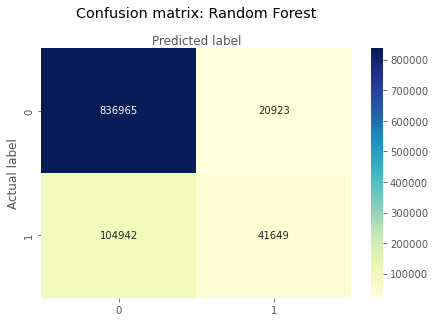

Accuracy: 0.8746962355609226
Precision: 0.6656172089752606
Recall: 0.2841170331057159


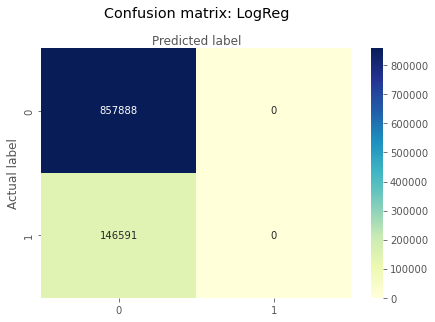

Accuracy: 0.854062653375531
Precision: 0.0
Recall: 0.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
model = ["Random Forest", "LogReg"]
for i in range(2):
    fig, ax = plt.subplots()
    class_names = [0, 1]  # name  of classes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix[i]), annot=True, cmap="YlGnBu", fmt="g")
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f"Confusion matrix: {model[i]}", y=1.1)
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()
    print("Accuracy:", metrics.accuracy_score(test_y, y_pred[i]))
    print("Precision:", metrics.precision_score(test_y, y_pred[i]))
    print("Recall:", metrics.recall_score(test_y, y_pred[i]))

In [111]:
from sklearn.metrics import classification_report

for i in range(2):
    print(f"{model[i]}:\n {classification_report(test_y, y_pred[i])}")

Random Forest:
               precision    recall  f1-score   support

       False       0.89      0.98      0.93    857888
        True       0.67      0.28      0.40    146591

    accuracy                           0.87   1004479
   macro avg       0.78      0.63      0.66   1004479
weighted avg       0.86      0.87      0.85   1004479



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogReg:
               precision    recall  f1-score   support

       False       0.85      1.00      0.92    857888
        True       0.00      0.00      0.00    146591

    accuracy                           0.85   1004479
   macro avg       0.43      0.50      0.46   1004479
weighted avg       0.73      0.85      0.79   1004479



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. Data Modeling: Clustering technique to predict the DepartureDelayGroups

In [33]:
# Subset the features we are using here
# 'Cancelled', 'Diverted', 'ArrivalDelayGroups', 'DepDel15', 'ArrDel15' (post-flight data, need to be excluded)
columns = [
    "Year",
    "DayofMonth",
    "Month",
    "DayOfWeek",
    "Airline",
    "Origin",
    "Dest",
    "Distance",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "OriginRegion",
    "DestRegion",
]

X = df_2020[columns].copy()
y = df_2020["DepartureDelayGroups"].copy()

In [34]:
X.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5022391 entries, 0 to 5022396
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   Year            5022391 non-null  int64   
 1   DayofMonth      5022391 non-null  int64   
 2   Month           5022391 non-null  int64   
 3   DayOfWeek       5022391 non-null  int64   
 4   Airline         5022391 non-null  category
 5   Location_pair   5022391 non-null  category
 6   Distance        5022391 non-null  float64 
 7   CRSDepTime      5022391 non-null  int64   
 8   CRSArrTime      5022391 non-null  int64   
 9   CRSElapsedTime  5022391 non-null  float64 
 10  OriginRegion    5022391 non-null  category
 11  DestRegion      5022391 non-null  category
dtypes: category(4), float64(2), int64(6)
memory usage: 369.1 MB


In [35]:
X = pd.get_dummies(X, drop_first=True)
X.head()

In [36]:
X.shape

(5022391, 796)

In [ ]:
# Standardization:
X =  standardize(X)

In [ ]:
# Apply PCA
pca = fit_pca(X, 10)
plot_variance(pca)

In [ ]:
# Reduce dimension
